<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:19] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


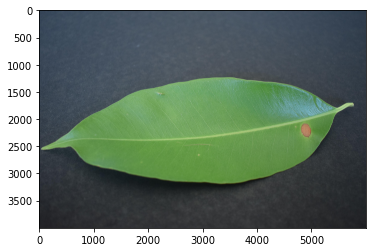

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

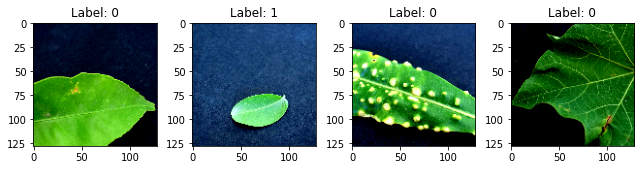

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:25] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2509194068435303 samples/sec                   batch loss = 0.7304176092147827 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2610787199295002 samples/sec                   batch loss = 0.39419057965278625 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.260130013218539 samples/sec                   batch loss = 0.9556182026863098 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2228566064019513 samples/sec                   batch loss = 0.7977192997932434 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.266379693741899 samples/sec                   batch loss = 0.44735991954803467 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2618095983387678 samples/sec                   batch loss = 0.23077018558979034 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2592897223030572 samples/sec                   batch loss = 0.8418084979057312 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2653489367645918 samples/sec                   batch loss = 0.2390223890542984 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.257803801027102 samples/sec                   batch loss = 0.662858784198761 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.2634913830725965 samples/sec                   batch loss = 0.5291871428489685 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2654927713512478 samples/sec                   batch loss = 1.9550464153289795 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2584795314618833 samples/sec                   batch loss = 1.0968726873397827 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2688889925883224 samples/sec                   batch loss = 0.27869123220443726 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.273388912801572 samples/sec                   batch loss = 0.8844899535179138 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2623351854417013 samples/sec                   batch loss = 0.48185595870018005 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2690535994078178 samples/sec                   batch loss = 0.7828388214111328 | accuracy = 0.640625


Epoch[1] Batch[85] Speed: 1.2746254938378954 samples/sec                   batch loss = 0.4603627920150757 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.2684021408253754 samples/sec                   batch loss = 0.3269149959087372 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.268928436745976 samples/sec                   batch loss = 0.5832202434539795 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2746059328848882 samples/sec                   batch loss = 1.254158854484558 | accuracy = 0.6425


Epoch[1] Batch[105] Speed: 1.273897205100808 samples/sec                   batch loss = 0.5332247018814087 | accuracy = 0.65


Epoch[1] Batch[110] Speed: 1.2708438970509257 samples/sec                   batch loss = 0.9864595532417297 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.2673236692555179 samples/sec                   batch loss = 0.5977012515068054 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.2718993465006616 samples/sec                   batch loss = 0.3619970381259918 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2691967412694392 samples/sec                   batch loss = 0.5591714978218079 | accuracy = 0.648


Epoch[1] Batch[130] Speed: 1.2732854089761025 samples/sec                   batch loss = 0.2901367247104645 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.275132351136086 samples/sec                   batch loss = 1.1495651006698608 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2568504095330317 samples/sec                   batch loss = 0.7227861285209656 | accuracy = 0.6553571428571429


Epoch[1] Batch[145] Speed: 1.2532166438353658 samples/sec                   batch loss = 0.4706459045410156 | accuracy = 0.656896551724138


Epoch[1] Batch[150] Speed: 1.257385725104709 samples/sec                   batch loss = 0.3986119031906128 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.2589522758400435 samples/sec                   batch loss = 0.9864232540130615 | accuracy = 0.6580645161290323


Epoch[1] Batch[160] Speed: 1.2626491704794514 samples/sec                   batch loss = 0.494096964597702 | accuracy = 0.659375


Epoch[1] Batch[165] Speed: 1.2633715961997982 samples/sec                   batch loss = 0.8357202410697937 | accuracy = 0.6621212121212121


Epoch[1] Batch[170] Speed: 1.2657130247488713 samples/sec                   batch loss = 0.7059780359268188 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.2677232830776723 samples/sec                   batch loss = 0.5945465564727783 | accuracy = 0.6571428571428571


Epoch[1] Batch[180] Speed: 1.2664686933679248 samples/sec                   batch loss = 0.5785828828811646 | accuracy = 0.6583333333333333


Epoch[1] Batch[185] Speed: 1.2677313296529777 samples/sec                   batch loss = 0.7148630619049072 | accuracy = 0.6581081081081082


Epoch[1] Batch[190] Speed: 1.2659480653322508 samples/sec                   batch loss = 0.48267999291419983 | accuracy = 0.6552631578947369


Epoch[1] Batch[195] Speed: 1.2621870349473927 samples/sec                   batch loss = 0.5739391446113586 | accuracy = 0.6576923076923077


Epoch[1] Batch[200] Speed: 1.267436738330527 samples/sec                   batch loss = 0.14965669810771942 | accuracy = 0.66125


Epoch[1] Batch[205] Speed: 1.2599571152978468 samples/sec                   batch loss = 0.4542810618877411 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.2686555449068941 samples/sec                   batch loss = 0.6040711998939514 | accuracy = 0.6666666666666666


Epoch[1] Batch[215] Speed: 1.2708912607712273 samples/sec                   batch loss = 0.4215119481086731 | accuracy = 0.672093023255814


Epoch[1] Batch[220] Speed: 1.2674601971854693 samples/sec                   batch loss = 0.530265212059021 | accuracy = 0.675


Epoch[1] Batch[225] Speed: 1.265199791833311 samples/sec                   batch loss = 0.3180575966835022 | accuracy = 0.6766666666666666


Epoch[1] Batch[230] Speed: 1.2687669327763345 samples/sec                   batch loss = 0.3583601117134094 | accuracy = 0.6793478260869565


Epoch[1] Batch[235] Speed: 1.2684155662079148 samples/sec                   batch loss = 0.5952072739601135 | accuracy = 0.6797872340425531


Epoch[1] Batch[240] Speed: 1.2690707824060659 samples/sec                   batch loss = 1.1490962505340576 | accuracy = 0.6770833333333334


Epoch[1] Batch[245] Speed: 1.2682266780296862 samples/sec                   batch loss = 1.115164041519165 | accuracy = 0.6755102040816326


Epoch[1] Batch[250] Speed: 1.266333334767441 samples/sec                   batch loss = 0.45455503463745117 | accuracy = 0.674


Epoch[1] Batch[255] Speed: 1.259966199065037 samples/sec                   batch loss = 1.240821123123169 | accuracy = 0.6735294117647059


Epoch[1] Batch[260] Speed: 1.2573131675198155 samples/sec                   batch loss = 0.5403175354003906 | accuracy = 0.675


Epoch[1] Batch[265] Speed: 1.2629922148978767 samples/sec                   batch loss = 0.2996082305908203 | accuracy = 0.6764150943396227


Epoch[1] Batch[270] Speed: 1.257058716781132 samples/sec                   batch loss = 0.40319564938545227 | accuracy = 0.6787037037037037


Epoch[1] Batch[275] Speed: 1.2557038849302953 samples/sec                   batch loss = 0.5097813010215759 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.253590267835374 samples/sec                   batch loss = 0.43673500418663025 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2525047532902742 samples/sec                   batch loss = 0.34076571464538574 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.2532236647890589 samples/sec                   batch loss = 0.9494407176971436 | accuracy = 0.6758620689655173


Epoch[1] Batch[295] Speed: 1.254774506230114 samples/sec                   batch loss = 0.7552327513694763 | accuracy = 0.673728813559322


Epoch[1] Batch[300] Speed: 1.256064135484579 samples/sec                   batch loss = 0.22641363739967346 | accuracy = 0.675


Epoch[1] Batch[305] Speed: 1.2657707023688325 samples/sec                   batch loss = 0.6710401773452759 | accuracy = 0.6737704918032786


Epoch[1] Batch[310] Speed: 1.2576355002910358 samples/sec                   batch loss = 0.35442429780960083 | accuracy = 0.675


Epoch[1] Batch[315] Speed: 1.2637975659950405 samples/sec                   batch loss = 0.38852986693382263 | accuracy = 0.6753968253968254


Epoch[1] Batch[320] Speed: 1.2611333215818499 samples/sec                   batch loss = 0.3369919955730438 | accuracy = 0.67421875


Epoch[1] Batch[325] Speed: 1.2680903683212021 samples/sec                   batch loss = 0.21801237761974335 | accuracy = 0.6761538461538461


Epoch[1] Batch[330] Speed: 1.2647729717643466 samples/sec                   batch loss = 0.7596184015274048 | accuracy = 0.6772727272727272


Epoch[1] Batch[335] Speed: 1.2598295778975708 samples/sec                   batch loss = 0.6108999252319336 | accuracy = 0.6783582089552239


Epoch[1] Batch[340] Speed: 1.2563856398999638 samples/sec                   batch loss = 1.3558412790298462 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.2608478527121407 samples/sec                   batch loss = 0.46150365471839905 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.2707524527016834 samples/sec                   batch loss = 0.53632652759552 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.264337578384228 samples/sec                   batch loss = 0.15606579184532166 | accuracy = 0.680281690140845


Epoch[1] Batch[360] Speed: 1.2659332593064552 samples/sec                   batch loss = 0.41783663630485535 | accuracy = 0.6798611111111111


Epoch[1] Batch[365] Speed: 1.2648210282816583 samples/sec                   batch loss = 0.5000438690185547 | accuracy = 0.6808219178082192


Epoch[1] Batch[370] Speed: 1.2606219008012964 samples/sec                   batch loss = 0.7749807238578796 | accuracy = 0.6777027027027027


Epoch[1] Batch[375] Speed: 1.2621824770220973 samples/sec                   batch loss = 0.3500656485557556 | accuracy = 0.6793333333333333


Epoch[1] Batch[380] Speed: 1.2649799077602732 samples/sec                   batch loss = 1.0851713418960571 | accuracy = 0.6789473684210526


Epoch[1] Batch[385] Speed: 1.2512822363989788 samples/sec                   batch loss = 0.8927072882652283 | accuracy = 0.6772727272727272


Epoch[1] Batch[390] Speed: 1.2664162097980116 samples/sec                   batch loss = 0.6711276173591614 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2612696567627038 samples/sec                   batch loss = 0.5712573528289795 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.2607903386091912 samples/sec                   batch loss = 0.7830387353897095 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2640971349359038 samples/sec                   batch loss = 0.5038206577301025 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.2631764084420085 samples/sec                   batch loss = 0.4447581470012665 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2554671835041054 samples/sec                   batch loss = 0.28349971771240234 | accuracy = 0.6771084337349398


Epoch[1] Batch[420] Speed: 1.2585020934883162 samples/sec                   batch loss = 0.6158356666564941 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2575335046251257 samples/sec                   batch loss = 0.3890959620475769 | accuracy = 0.6776470588235294


Epoch[1] Batch[430] Speed: 1.2508536554361183 samples/sec                   batch loss = 0.5974439382553101 | accuracy = 0.6773255813953488


Epoch[1] Batch[435] Speed: 1.2622980495838916 samples/sec                   batch loss = 0.5785590410232544 | accuracy = 0.6798850574712644


Epoch[1] Batch[440] Speed: 1.2558053960088702 samples/sec                   batch loss = 0.3916214406490326 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.253448470498019 samples/sec                   batch loss = 0.47167181968688965 | accuracy = 0.6814606741573034


Epoch[1] Batch[450] Speed: 1.257110050823997 samples/sec                   batch loss = 0.2493087649345398 | accuracy = 0.6816666666666666


Epoch[1] Batch[455] Speed: 1.2561943917261904 samples/sec                   batch loss = 0.7101492881774902 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.2521110303762688 samples/sec                   batch loss = 0.43997836112976074 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.2465426292103892 samples/sec                   batch loss = 0.20431776344776154 | accuracy = 0.6844086021505377


Epoch[1] Batch[470] Speed: 1.2473299141801675 samples/sec                   batch loss = 1.012526273727417 | accuracy = 0.6840425531914893


Epoch[1] Batch[475] Speed: 1.2548132654425046 samples/sec                   batch loss = 0.3810495436191559 | accuracy = 0.6857894736842105


Epoch[1] Batch[480] Speed: 1.2606268263525247 samples/sec                   batch loss = 0.8186928629875183 | accuracy = 0.6864583333333333


Epoch[1] Batch[485] Speed: 1.2604587163200518 samples/sec                   batch loss = 0.40060150623321533 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.259255411868868 samples/sec                   batch loss = 0.38555675745010376 | accuracy = 0.688265306122449


Epoch[1] Batch[495] Speed: 1.2571150431656142 samples/sec                   batch loss = 0.2201181799173355 | accuracy = 0.6898989898989899


Epoch[1] Batch[500] Speed: 1.2593661004508874 samples/sec                   batch loss = 0.2635140120983124 | accuracy = 0.691


Epoch[1] Batch[505] Speed: 1.2551946035332184 samples/sec                   batch loss = 1.3100388050079346 | accuracy = 0.69009900990099


Epoch[1] Batch[510] Speed: 1.2563976830518726 samples/sec                   batch loss = 0.38439691066741943 | accuracy = 0.6916666666666667


Epoch[1] Batch[515] Speed: 1.2592544667043055 samples/sec                   batch loss = 0.6746610403060913 | accuracy = 0.6893203883495146


Epoch[1] Batch[520] Speed: 1.2568442894328977 samples/sec                   batch loss = 0.7328898906707764 | accuracy = 0.6889423076923077


Epoch[1] Batch[525] Speed: 1.2565960519259518 samples/sec                   batch loss = 0.8332701921463013 | accuracy = 0.69


Epoch[1] Batch[530] Speed: 1.2565300788547291 samples/sec                   batch loss = 0.8593767881393433 | accuracy = 0.690566037735849


Epoch[1] Batch[535] Speed: 1.251673477158913 samples/sec                   batch loss = 0.3644653856754303 | accuracy = 0.6901869158878504


Epoch[1] Batch[540] Speed: 1.2513913409935966 samples/sec                   batch loss = 0.6303790807723999 | accuracy = 0.6907407407407408


Epoch[1] Batch[545] Speed: 1.252942794417042 samples/sec                   batch loss = 0.19551336765289307 | accuracy = 0.6922018348623853


Epoch[1] Batch[550] Speed: 1.2523956414475588 samples/sec                   batch loss = 0.5836334824562073 | accuracy = 0.6931818181818182


Epoch[1] Batch[555] Speed: 1.250532086092029 samples/sec                   batch loss = 0.46897825598716736 | accuracy = 0.6932432432432433


Epoch[1] Batch[560] Speed: 1.2632122644382655 samples/sec                   batch loss = 0.5756229758262634 | accuracy = 0.6933035714285715


Epoch[1] Batch[565] Speed: 1.2560946986029204 samples/sec                   batch loss = 0.727554440498352 | accuracy = 0.6933628318584071


Epoch[1] Batch[570] Speed: 1.2706396573823389 samples/sec                   batch loss = 0.2519386410713196 | accuracy = 0.6942982456140351


Epoch[1] Batch[575] Speed: 1.2645131103079592 samples/sec                   batch loss = 0.7164831757545471 | accuracy = 0.6947826086956522


Epoch[1] Batch[580] Speed: 1.2594526987651187 samples/sec                   batch loss = 0.25861793756484985 | accuracy = 0.6952586206896552


Epoch[1] Batch[585] Speed: 1.2569890222224287 samples/sec                   batch loss = 0.6523525714874268 | accuracy = 0.6944444444444444


Epoch[1] Batch[590] Speed: 1.2622904517236735 samples/sec                   batch loss = 0.5757681727409363 | accuracy = 0.6944915254237288


Epoch[1] Batch[595] Speed: 1.2531946453565317 samples/sec                   batch loss = 0.3453443646430969 | accuracy = 0.6949579831932773


Epoch[1] Batch[600] Speed: 1.2580978932587008 samples/sec                   batch loss = 0.48340943455696106 | accuracy = 0.6945833333333333


Epoch[1] Batch[605] Speed: 1.2598329836053361 samples/sec                   batch loss = 0.3720357418060303 | accuracy = 0.6958677685950413


Epoch[1] Batch[610] Speed: 1.2553095573566275 samples/sec                   batch loss = 1.2658292055130005 | accuracy = 0.6954918032786885


Epoch[1] Batch[615] Speed: 1.2603350538484497 samples/sec                   batch loss = 1.0031708478927612 | accuracy = 0.6951219512195121


Epoch[1] Batch[620] Speed: 1.2628179604017542 samples/sec                   batch loss = 0.16451722383499146 | accuracy = 0.6967741935483871


Epoch[1] Batch[625] Speed: 1.2556146063436573 samples/sec                   batch loss = 0.49713656306266785 | accuracy = 0.6948


Epoch[1] Batch[630] Speed: 1.2578189833081914 samples/sec                   batch loss = 0.3990260660648346 | accuracy = 0.6956349206349206


Epoch[1] Batch[635] Speed: 1.2574384052735434 samples/sec                   batch loss = 0.6327444314956665 | accuracy = 0.694488188976378


Epoch[1] Batch[640] Speed: 1.2575110715689755 samples/sec                   batch loss = 0.5999209880828857 | accuracy = 0.694140625


Epoch[1] Batch[645] Speed: 1.2590868169596368 samples/sec                   batch loss = 0.6450595259666443 | accuracy = 0.6953488372093023


Epoch[1] Batch[650] Speed: 1.2597512517007212 samples/sec                   batch loss = 0.4091811180114746 | accuracy = 0.6961538461538461


Epoch[1] Batch[655] Speed: 1.2582481050024037 samples/sec                   batch loss = 0.7184178829193115 | accuracy = 0.6969465648854962


Epoch[1] Batch[660] Speed: 1.2591847174755206 samples/sec                   batch loss = 0.6927694082260132 | accuracy = 0.696969696969697


Epoch[1] Batch[665] Speed: 1.2574652653770686 samples/sec                   batch loss = 0.6742251515388489 | accuracy = 0.6969924812030075


Epoch[1] Batch[670] Speed: 1.2622885522729101 samples/sec                   batch loss = 1.3965232372283936 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.2613133698999488 samples/sec                   batch loss = 0.6399996280670166 | accuracy = 0.6962962962962963


Epoch[1] Batch[680] Speed: 1.2551862457838046 samples/sec                   batch loss = 0.27505141496658325 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.2565537944822143 samples/sec                   batch loss = 0.7054908275604248 | accuracy = 0.6974452554744526


Epoch[1] Batch[690] Speed: 1.255085961471594 samples/sec                   batch loss = 0.5308995246887207 | accuracy = 0.6978260869565217


Epoch[1] Batch[695] Speed: 1.2542612898323011 samples/sec                   batch loss = 0.21332372725009918 | accuracy = 0.6974820143884892


Epoch[1] Batch[700] Speed: 1.2570207605428383 samples/sec                   batch loss = 0.6346011161804199 | accuracy = 0.6978571428571428


Epoch[1] Batch[705] Speed: 1.258789051069698 samples/sec                   batch loss = 0.2963707149028778 | accuracy = 0.6985815602836879


Epoch[1] Batch[710] Speed: 1.2589948837153806 samples/sec                   batch loss = 0.33822259306907654 | accuracy = 0.6992957746478873


Epoch[1] Batch[715] Speed: 1.2594199866485334 samples/sec                   batch loss = 0.5375770330429077 | accuracy = 0.7


Epoch[1] Batch[720] Speed: 1.2571276654892065 samples/sec                   batch loss = 0.5862234830856323 | accuracy = 0.7003472222222222


Epoch[1] Batch[725] Speed: 1.2549870074574156 samples/sec                   batch loss = 0.46768176555633545 | accuracy = 0.7006896551724138


Epoch[1] Batch[730] Speed: 1.2590173697434337 samples/sec                   batch loss = 0.2483111023902893 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2579982751016425 samples/sec                   batch loss = 0.9066779613494873 | accuracy = 0.7010204081632653


Epoch[1] Batch[740] Speed: 1.2592320667194512 samples/sec                   batch loss = 0.6483791470527649 | accuracy = 0.7013513513513514


Epoch[1] Batch[745] Speed: 1.2566397240746212 samples/sec                   batch loss = 0.505250096321106 | accuracy = 0.7023489932885906


Epoch[1] Batch[750] Speed: 1.25528447984964 samples/sec                   batch loss = 0.42002207040786743 | accuracy = 0.7036666666666667


Epoch[1] Batch[755] Speed: 1.2657431043087297 samples/sec                   batch loss = 0.7220829725265503 | accuracy = 0.7043046357615894


Epoch[1] Batch[760] Speed: 1.2636851452661828 samples/sec                   batch loss = 0.80414217710495 | accuracy = 0.7052631578947368


Epoch[1] Batch[765] Speed: 1.2628284162166248 samples/sec                   batch loss = 0.13795697689056396 | accuracy = 0.7055555555555556


Epoch[1] Batch[770] Speed: 1.2602568541217951 samples/sec                   batch loss = 0.36250507831573486 | accuracy = 0.7061688311688312


Epoch[1] Batch[775] Speed: 1.2562358724890208 samples/sec                   batch loss = 0.9177786111831665 | accuracy = 0.7070967741935484


Epoch[1] Batch[780] Speed: 1.2545190181273682 samples/sec                   batch loss = 0.49101611971855164 | accuracy = 0.7080128205128206


Epoch[1] Batch[785] Speed: 1.2542918590501222 samples/sec                   batch loss = 0.2867589592933655 | accuracy = 0.7085987261146497


[Epoch 1] training: accuracy=0.7084390862944162
[Epoch 1] time cost: 650.8116867542267
[Epoch 1] validation: validation accuracy=0.7544444444444445


Epoch[2] Batch[5] Speed: 1.273701749307414 samples/sec                   batch loss = 0.06586857885122299 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2731173839789305 samples/sec                   batch loss = 0.8224269151687622 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2772166126005309 samples/sec                   batch loss = 0.2267976701259613 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2644585015067114 samples/sec                   batch loss = 0.6394909620285034 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2632501199270265 samples/sec                   batch loss = 0.24495939910411835 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2660833415778243 samples/sec                   batch loss = 0.1345897614955902 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2685445602580396 samples/sec                   batch loss = 0.4153363108634949 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2658165426368029 samples/sec                   batch loss = 1.0129209756851196 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2683867978790384 samples/sec                   batch loss = 0.9430980682373047 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2694167492151462 samples/sec                   batch loss = 0.4322217106819153 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2665215637297413 samples/sec                   batch loss = 0.6509253978729248 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2626086904168805 samples/sec                   batch loss = 0.19647730886936188 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2609287792973147 samples/sec                   batch loss = 0.24395322799682617 | accuracy = 0.7692307692307693


Epoch[2] Batch[70] Speed: 1.2642432572551572 samples/sec                   batch loss = 0.8230751156806946 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2601999618722497 samples/sec                   batch loss = 0.27826038002967834 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2640626572806117 samples/sec                   batch loss = 0.7496826648712158 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2690978537718847 samples/sec                   batch loss = 0.39975735545158386 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2625895915702816 samples/sec                   batch loss = 0.38088351488113403 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2583102004840274 samples/sec                   batch loss = 0.6218539476394653 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2644186676950502 samples/sec                   batch loss = 0.35510456562042236 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2684567071856387 samples/sec                   batch loss = 0.27453264594078064 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2595707034097912 samples/sec                   batch loss = 0.5967260003089905 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2627147422851734 samples/sec                   batch loss = 0.4309365749359131 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.2629029426757692 samples/sec                   batch loss = 0.44836077094078064 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2648788153582673 samples/sec                   batch loss = 0.41918960213661194 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2648484907883697 samples/sec                   batch loss = 0.14251181483268738 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.262074330910621 samples/sec                   batch loss = 0.16750428080558777 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.2643832196191886 samples/sec                   batch loss = 0.24087847769260406 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.262713031629813 samples/sec                   batch loss = 0.5964611172676086 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.2699152421777498 samples/sec                   batch loss = 0.5853657126426697 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2647035632415253 samples/sec                   batch loss = 0.21885086596012115 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.263934573073681 samples/sec                   batch loss = 0.42299556732177734 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2619868021514202 samples/sec                   batch loss = 0.7803838849067688 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2684010859859323 samples/sec                   batch loss = 0.5153476595878601 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2660234381484918 samples/sec                   batch loss = 0.24569492042064667 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.263315563912124 samples/sec                   batch loss = 0.37883347272872925 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.260369896561151 samples/sec                   batch loss = 0.6323668956756592 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2657269662083843 samples/sec                   batch loss = 0.6936475038528442 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2718022548444528 samples/sec                   batch loss = 0.436573326587677 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2635490487127774 samples/sec                   batch loss = 0.8449303507804871 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2654600310760458 samples/sec                   batch loss = 0.24657344818115234 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.2605175260545174 samples/sec                   batch loss = 0.5793850421905518 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.263849071078749 samples/sec                   batch loss = 0.33063873648643494 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.259574864233512 samples/sec                   batch loss = 0.5406591892242432 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2602898937424862 samples/sec                   batch loss = 0.6099857091903687 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.256820468687542 samples/sec                   batch loss = 0.9053148627281189 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.26918281928195 samples/sec                   batch loss = 0.2906535267829895 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.2703126449261783 samples/sec                   batch loss = 0.41868194937705994 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2606354461597926 samples/sec                   batch loss = 0.8726189136505127 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2685253773260567 samples/sec                   batch loss = 0.7782843112945557 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.266036048925698 samples/sec                   batch loss = 0.6559001207351685 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2726288272622608 samples/sec                   batch loss = 0.2355879843235016 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.2699479250088639 samples/sec                   batch loss = 0.31236428022384644 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.2717898181561824 samples/sec                   batch loss = 0.5207686424255371 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2699428302215707 samples/sec                   batch loss = 0.08839480578899384 | accuracy = 0.7536363636363637


Epoch[2] Batch[280] Speed: 1.2692350523150815 samples/sec                   batch loss = 0.47857505083084106 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.268697277088705 samples/sec                   batch loss = 0.6332712769508362 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.2689783452771726 samples/sec                   batch loss = 0.14496026933193207 | accuracy = 0.7508620689655172


Epoch[2] Batch[295] Speed: 1.2711135901181567 samples/sec                   batch loss = 0.2602320909500122 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.268376825162966 samples/sec                   batch loss = 0.4672016203403473 | accuracy = 0.7516666666666667


Epoch[2] Batch[305] Speed: 1.2733036731343974 samples/sec                   batch loss = 0.34893882274627686 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.2646930763524964 samples/sec                   batch loss = 0.7067553997039795 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2675383357980645 samples/sec                   batch loss = 0.5054898858070374 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2699964717307362 samples/sec                   batch loss = 0.8823963403701782 | accuracy = 0.746875


Epoch[2] Batch[325] Speed: 1.2722567946411962 samples/sec                   batch loss = 0.22383680939674377 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.2643741673377704 samples/sec                   batch loss = 0.3559024930000305 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2765986134812466 samples/sec                   batch loss = 0.4306366443634033 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.274757206973547 samples/sec                   batch loss = 0.23066706955432892 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.2772044587161173 samples/sec                   batch loss = 0.4970565140247345 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2758692331863788 samples/sec                   batch loss = 0.2780568301677704 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.273433373392166 samples/sec                   batch loss = 0.09522169828414917 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2726505479487698 samples/sec                   batch loss = 1.3275655508041382 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.2683748114604811 samples/sec                   batch loss = 0.48538580536842346 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.2671011324310952 samples/sec                   batch loss = 0.18230712413787842 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.272008604390174 samples/sec                   batch loss = 0.1636556088924408 | accuracy = 0.7546666666666667


Epoch[2] Batch[380] Speed: 1.2654145029553991 samples/sec                   batch loss = 0.17451323568820953 | accuracy = 0.7552631578947369


Epoch[2] Batch[385] Speed: 1.262252938629506 samples/sec                   batch loss = 0.30560219287872314 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2625065515623477 samples/sec                   batch loss = 0.08839111030101776 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.2614886321615082 samples/sec                   batch loss = 0.6711099147796631 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2602158646793316 samples/sec                   batch loss = 0.5738937258720398 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2636550682596184 samples/sec                   batch loss = 0.1922168731689453 | accuracy = 0.7561728395061729


Epoch[2] Batch[410] Speed: 1.2707102002321742 samples/sec                   batch loss = 0.5653230547904968 | accuracy = 0.7560975609756098


Epoch[2] Batch[415] Speed: 1.2748950506714294 samples/sec                   batch loss = 0.37605467438697815 | accuracy = 0.7572289156626506


Epoch[2] Batch[420] Speed: 1.2693018861415233 samples/sec                   batch loss = 0.42154794931411743 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.2678098849207378 samples/sec                   batch loss = 0.19928300380706787 | accuracy = 0.758235294117647


Epoch[2] Batch[430] Speed: 1.263607195471348 samples/sec                   batch loss = 0.2513730525970459 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2687338309793332 samples/sec                   batch loss = 0.29723548889160156 | accuracy = 0.7586206896551724


Epoch[2] Batch[440] Speed: 1.2682377988204792 samples/sec                   batch loss = 0.30989834666252136 | accuracy = 0.7568181818181818


Epoch[2] Batch[445] Speed: 1.2729274792726113 samples/sec                   batch loss = 0.45387211441993713 | accuracy = 0.7573033707865169


Epoch[2] Batch[450] Speed: 1.2794440891961691 samples/sec                   batch loss = 0.219660684466362 | accuracy = 0.7594444444444445


Epoch[2] Batch[455] Speed: 1.2720461209158402 samples/sec                   batch loss = 0.18046730756759644 | accuracy = 0.7598901098901099


Epoch[2] Batch[460] Speed: 1.2799732427468482 samples/sec                   batch loss = 0.16865849494934082 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.2722169503493717 samples/sec                   batch loss = 0.46402931213378906 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.2715387262191138 samples/sec                   batch loss = 0.39431294798851013 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.261912288860693 samples/sec                   batch loss = 0.22336387634277344 | accuracy = 0.76


Epoch[2] Batch[480] Speed: 1.2683637841554924 samples/sec                   batch loss = 0.33229702711105347 | accuracy = 0.7598958333333333


Epoch[2] Batch[485] Speed: 1.2684052094591856 samples/sec                   batch loss = 0.45964571833610535 | accuracy = 0.7603092783505154


Epoch[2] Batch[490] Speed: 1.2705577682092317 samples/sec                   batch loss = 0.06698614358901978 | accuracy = 0.7612244897959184


Epoch[2] Batch[495] Speed: 1.2711312141772075 samples/sec                   batch loss = 0.3218368589878082 | accuracy = 0.7631313131313131


Epoch[2] Batch[500] Speed: 1.2759398727255526 samples/sec                   batch loss = 0.5142724514007568 | accuracy = 0.762


Epoch[2] Batch[505] Speed: 1.2775761805053234 samples/sec                   batch loss = 0.7146678566932678 | accuracy = 0.7628712871287129


Epoch[2] Batch[510] Speed: 1.270604052097049 samples/sec                   batch loss = 0.4812548756599426 | accuracy = 0.7622549019607843


Epoch[2] Batch[515] Speed: 1.2745365060327183 samples/sec                   batch loss = 0.5451534390449524 | accuracy = 0.7621359223300971


Epoch[2] Batch[520] Speed: 1.272006386258717 samples/sec                   batch loss = 0.24582123756408691 | accuracy = 0.7629807692307692


Epoch[2] Batch[525] Speed: 1.2670876391629793 samples/sec                   batch loss = 0.48177826404571533 | accuracy = 0.7619047619047619


Epoch[2] Batch[530] Speed: 1.2718616457952236 samples/sec                   batch loss = 0.6283965110778809 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.269638082507175 samples/sec                   batch loss = 0.6119091510772705 | accuracy = 0.7616822429906542


Epoch[2] Batch[540] Speed: 1.2675385273261077 samples/sec                   batch loss = 0.5820759534835815 | accuracy = 0.7611111111111111


Epoch[2] Batch[545] Speed: 1.2825414618980315 samples/sec                   batch loss = 0.29172730445861816 | accuracy = 0.7628440366972477


Epoch[2] Batch[550] Speed: 1.302876277659652 samples/sec                   batch loss = 0.9571408629417419 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.30205654300018 samples/sec                   batch loss = 0.2763161063194275 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.2990106369305432 samples/sec                   batch loss = 0.4615064561367035 | accuracy = 0.7638392857142857


Epoch[2] Batch[565] Speed: 1.302051591529393 samples/sec                   batch loss = 0.5150887966156006 | accuracy = 0.7632743362831859


Epoch[2] Batch[570] Speed: 1.2929685519139034 samples/sec                   batch loss = 0.39380601048469543 | accuracy = 0.7631578947368421


Epoch[2] Batch[575] Speed: 1.2907495829563855 samples/sec                   batch loss = 0.3452659845352173 | accuracy = 0.7630434782608696


Epoch[2] Batch[580] Speed: 1.2911238666449443 samples/sec                   batch loss = 0.46425557136535645 | accuracy = 0.7629310344827587


Epoch[2] Batch[585] Speed: 1.2974719999604043 samples/sec                   batch loss = 0.12626440823078156 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.29891157458 samples/sec                   batch loss = 0.46752747893333435 | accuracy = 0.7627118644067796


Epoch[2] Batch[595] Speed: 1.300887727941254 samples/sec                   batch loss = 0.50394606590271 | accuracy = 0.7617647058823529


Epoch[2] Batch[600] Speed: 1.2993809722485012 samples/sec                   batch loss = 0.8427636027336121 | accuracy = 0.7620833333333333


Epoch[2] Batch[605] Speed: 1.3004299417019267 samples/sec                   batch loss = 0.23907607793807983 | accuracy = 0.7628099173553718


Epoch[2] Batch[610] Speed: 1.3053077656993002 samples/sec                   batch loss = 0.6079512238502502 | accuracy = 0.7618852459016393


Epoch[2] Batch[615] Speed: 1.3037706984630204 samples/sec                   batch loss = 0.3323567807674408 | accuracy = 0.7626016260162601


Epoch[2] Batch[620] Speed: 1.3011691137436108 samples/sec                   batch loss = 0.40165460109710693 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.2983593150180637 samples/sec                   batch loss = 1.2249782085418701 | accuracy = 0.7632


Epoch[2] Batch[630] Speed: 1.2973906289498973 samples/sec                   batch loss = 1.1577746868133545 | accuracy = 0.7634920634920634


Epoch[2] Batch[635] Speed: 1.3024608717517598 samples/sec                   batch loss = 0.20473437011241913 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.3050950403759796 samples/sec                   batch loss = 0.7091058492660522 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.2980396735298558 samples/sec                   batch loss = 0.5406181812286377 | accuracy = 0.7635658914728682


Epoch[2] Batch[650] Speed: 1.300429538508093 samples/sec                   batch loss = 0.17298881709575653 | accuracy = 0.7634615384615384


Epoch[2] Batch[655] Speed: 1.303417906666473 samples/sec                   batch loss = 0.6460934281349182 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2989178095311018 samples/sec                   batch loss = 0.5181465744972229 | accuracy = 0.7632575757575758


Epoch[2] Batch[665] Speed: 1.3027394992488204 samples/sec                   batch loss = 0.7513488531112671 | accuracy = 0.762406015037594


Epoch[2] Batch[670] Speed: 1.298510551645876 samples/sec                   batch loss = 0.28071266412734985 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2875159450546196 samples/sec                   batch loss = 0.49631935358047485 | accuracy = 0.7633333333333333


Epoch[2] Batch[680] Speed: 1.2902090031696882 samples/sec                   batch loss = 0.3071271777153015 | accuracy = 0.7643382352941176


Epoch[2] Batch[685] Speed: 1.2942442704373327 samples/sec                   batch loss = 0.25980812311172485 | accuracy = 0.7631386861313869


Epoch[2] Batch[690] Speed: 1.2897574115700752 samples/sec                   batch loss = 0.6506727933883667 | accuracy = 0.7634057971014493


Epoch[2] Batch[695] Speed: 1.2968466787061013 samples/sec                   batch loss = 0.6982333064079285 | accuracy = 0.7636690647482014


Epoch[2] Batch[700] Speed: 1.292381012465843 samples/sec                   batch loss = 0.5538387298583984 | accuracy = 0.7635714285714286


Epoch[2] Batch[705] Speed: 1.2910663391933974 samples/sec                   batch loss = 0.6928707361221313 | accuracy = 0.7638297872340426


Epoch[2] Batch[710] Speed: 1.2917351266433859 samples/sec                   batch loss = 0.30302929878234863 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.2959562237077296 samples/sec                   batch loss = 0.481493204832077 | accuracy = 0.762937062937063


Epoch[2] Batch[720] Speed: 1.3009722620496769 samples/sec                   batch loss = 0.9185457825660706 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.2949252504239885 samples/sec                   batch loss = 0.2699129581451416 | accuracy = 0.7627586206896552


Epoch[2] Batch[730] Speed: 1.3008973106114619 samples/sec                   batch loss = 0.403575599193573 | accuracy = 0.7626712328767123


Epoch[2] Batch[735] Speed: 1.2971383534062335 samples/sec                   batch loss = 0.41691580414772034 | accuracy = 0.7625850340136054


Epoch[2] Batch[740] Speed: 1.3003379191931421 samples/sec                   batch loss = 0.24350130558013916 | accuracy = 0.7631756756756757


Epoch[2] Batch[745] Speed: 1.2964002464651003 samples/sec                   batch loss = 0.13994114100933075 | accuracy = 0.763758389261745


Epoch[2] Batch[750] Speed: 1.2995223811324514 samples/sec                   batch loss = 0.7369498014450073 | accuracy = 0.7633333333333333


Epoch[2] Batch[755] Speed: 1.2933263768888166 samples/sec                   batch loss = 0.1853838860988617 | accuracy = 0.7642384105960265


Epoch[2] Batch[760] Speed: 1.2973592270848187 samples/sec                   batch loss = 0.4779540002346039 | accuracy = 0.7625


Epoch[2] Batch[765] Speed: 1.295764148474108 samples/sec                   batch loss = 0.28571128845214844 | accuracy = 0.7633986928104575


Epoch[2] Batch[770] Speed: 1.2913270918583017 samples/sec                   batch loss = 0.4809524118900299 | accuracy = 0.763961038961039


Epoch[2] Batch[775] Speed: 1.2944097295276311 samples/sec                   batch loss = 0.2863207757472992 | accuracy = 0.7641935483870967


Epoch[2] Batch[780] Speed: 1.291436233799523 samples/sec                   batch loss = 0.501272976398468 | accuracy = 0.7637820512820512


Epoch[2] Batch[785] Speed: 1.2892704676640268 samples/sec                   batch loss = 0.6956610083580017 | accuracy = 0.7640127388535032


[Epoch 2] training: accuracy=0.7639593908629442
[Epoch 2] time cost: 633.5084166526794
[Epoch 2] validation: validation accuracy=0.7477777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7355555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)